**Imports**

In [ ]:
import math
import numpy as np
from qiskit.circuit.library import Initialize
from qiskit.primitives.
from qiskit_algorithms import AmplitudeEstimation, EstimationProblem
from qiskit_aer import AerSimulator
from qiskit_ibm_runtime import QiskitRuntimeService, Sampler as IBMSampler

## Amplitude Estimation

## Amplitude Estimation

In [13]:
from math import log2, asin, sqrt
from typing import List, Tuple

import numpy as np
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator


class QuantumAmplitudeEstimator:
    """
    Measurement‐based amplitude estimation for mean & variance (Qiskit v2.0+),
    using a uniform superposition over indices (not weights ∝ x_i). Estimates the
    arithmetic mean and variance of a nonnegative dataset.

    - window_size: must be a power of 2 (the number of data points).
    - shots: number of measurement shots per amplitude estimate.

    predict(data) → (mean_est, variance_est).
    """

    def __init__(self, window_size: int, shots: int = 10_000) -> None:
        # window_size must be a power of 2
        if window_size & (window_size - 1) != 0:
            raise ValueError("window_size must be a power of 2.")
        self.window_size = window_size
        self.n_index_qubits = int(log2(window_size))
        self.shots = shots

        # Use AerSimulator (we only need to measure ancilla & index)
        self.backend = AerSimulator()

    def _build_A_circuit(self, values: List[float], encode_power: int) -> QuantumCircuit:
        """
        Build the “A” operator on (n_index_qubits + 1) qubits:

          |0^n> |0>  →  (1/√N) ∑_i |i> [cos(theta_i)|0> + sin(theta_i)|1>]

        where:
          - encode_power=1: θ_i = arcsin(sqrt(x_i / X_max))
              → sin^2(θ_i) = x_i / X_max = f(i)
              => ancilla “1” probability = (1/N) ∑_i x_i/X_max = E[X]/X_max.
          - encode_power=2: θ_i = arcsin(x_i / X_max)
              → sin^2(θ_i) = x_i^2 / X_max^2 = g(i)
              => ancilla “1” probability = (1/N) ∑_i x_i^2/X_max^2 = E[X^2]/X_max^2.

        values: length = window_size, all ≥ 0.
        encode_power: 1 (for mean pass) or 2 (for second moment pass).
        """
        N = self.window_size
        n = self.n_index_qubits

        X_max = max(values)
        if X_max <= 0:
            raise ValueError("All data values are zero; cannot normalize nonzero range.")

        # Build circuit on n index qubits + 1 ancilla + n+1 classical bits
        qc = QuantumCircuit(n + 1, n + 1)

        # 1) Prepare uniform superposition on index qubits
        qc.h(range(n))

        # 2) For each basis index |i>, rotate ancilla by 2θ_i, controlled on |i>
        ancilla = n
        for i in range(N):
            x_i = values[i]
            if encode_power == 1:
                # want sin(θ_i) = sqrt(x_i / X_max)
                sin_theta = sqrt(x_i / X_max)
            else:  # encode_power == 2
                # want sin(θ_i) = x_i / X_max
                sin_theta = x_i / X_max

            # Clamp to [0,1]
            sin_theta = max(0.0, min(1.0, sin_theta))
            theta = asin(sin_theta)
            angle = 2.0 * float(theta)

            # Build binary string for index i (length n)
            bitstr = format(i, f"0{n}b")

            # 2a) Flip index qubits that are '0' to '1' for mcry control
            for q_idx, bit in enumerate(bitstr):
                if bit == "0":
                    qc.x(q_idx)

            # 2b) Apply multi‐controlled Ry(angle) with all n index qubits controlling ancilla
            qc.mcry(angle, list(range(n)), ancilla, None, mode="noancilla")

            # 2c) Undo the X flips on index qubits
            for q_idx, bit in enumerate(bitstr):
                if bit == "0":
                    qc.x(q_idx)

        # 3) Measure ancilla in cbit 0, and index qubits in next n cbits
        qc.measure(range(n + 1), range(n + 1))
        return qc

    def _estimate_amplitude(self, values: List[float], encode_power: int) -> float:
        """
        Build A with given encode_power, run 'shots' times, measure ancilla repeatedly.
        Return empirical frequency of ancilla=1, which approximates:
          - encode_power=1: E[X] / X_max
          - encode_power=2: E[X^2] / X_max^2
        """
        qc = self._build_A_circuit(values, encode_power=encode_power)
        t_qc = transpile(qc, self.backend)
        job = self.backend.run(t_qc, shots=self.shots)
        result = job.result()
        counts = result.get_counts()

        # Each key is a bitstring of length (n_index_qubits+1),
        # with bit 0 = ancilla measurement (MSB of string returned by get_counts).
        total_counts = sum(counts.values())
        ancilla_one_counts = 0
        for bitstr, cnt in counts.items():
            # bitstr[0] is the ancilla bit (since measure() stored ancilla as cbit 0)
            if bitstr[0] == "1":
                ancilla_one_counts += cnt

        return ancilla_one_counts / total_counts

    def predict(self, data: List[float]) -> Tuple[float, float]:
        """
        Estimate (mean, variance) for nonnegative `data` list of length = window_size.

        Returns: (mean_estimate, variance_estimate).
        """
        if len(data) != self.window_size:
            raise ValueError(f"Expected {self.window_size} data points, got {len(data)}.")
        if any(x < 0 for x in data):
            raise ValueError("All data values must be nonnegative.")

        X_max = max(data)
        if X_max <= 0:
            # All data zeros → mean = var = 0
            return 0.0, 0.0

        # Pass 1: estimate a1 ≈ E[X] / X_max
        a1 = self._estimate_amplitude(data, encode_power=1)
        E_X = a1 * X_max

        # Pass 2: estimate a2 ≈ E[X^2] / X_max^2
        a2 = self._estimate_amplitude(data, encode_power=2)
        E_X2 = a2 * (X_max**2)

        var_X = E_X2 - (E_X**2)
        return E_X, var_X


In [14]:
"""
test_quantum_amplitude_estimator.py

Test script for the corrected QuantumAmplitudeEstimator (Qiskit v2.0+),
which uses a uniform superposition over indices and measures the ancilla,
so that the quantum-estimated mean/variance match the classical arithmetic
mean/variance.

Run with:
    python test_quantum_amplitude_estimator.py
"""

import numpy as np

# If the QuantumAmplitudeEstimator class is in a separate module, import it:
# from quantum_amplitude_estimator import QuantumAmplitudeEstimator

# Otherwise, if the class definition is in the same file, skip the import above.

def run_test_case(data: np.ndarray, shots: int, tol: float):
    """
    Instantiate the estimator on `data`, compare quantum vs classical mean & variance.
    """
    N = len(data)
    print(f"\nTesting data (length={N}): {data.tolist()}")

    # Classical mean and variance (arithmetic, uniform weights)
    mean_cl = np.mean(data)
    var_cl = np.var(data)

    # Create the quantum estimator
    qae = QuantumAmplitudeEstimator(window_size=N, shots=shots)

    # Run quantum estimate
    mean_q, var_q = qae.predict(data.tolist())

    print(f" Classical mean = {mean_cl:.6f}, variance = {var_cl:.6f}")
    print(f" Quantum  mean = {mean_q:.6f}, variance = {var_q:.6f}")

    mean_diff = abs(mean_q - mean_cl)
    var_diff = abs(var_q - var_cl)

    if mean_diff > tol:
        print(f"  → WARNING: mean differs by {mean_diff:.6f} > tol={tol}")
    if var_diff > tol:
        print(f"  → WARNING: variance differs by {var_diff:.6f} > tol={tol}")

    assert mean_diff <= tol, f"Mean not within tolerance: |{mean_q} - {mean_cl}| = {mean_diff} ≥ {tol}"
    assert var_diff <= tol, f"Variance not within tolerance: |{var_q} - {var_cl}| = {var_diff} ≥ {tol}"
    print("Test PASSED.")


if __name__ == "__main__":
    np.random.seed(42)

    shots = 20_0000   # increase to reduce sampling error
    tol = 0.10       # allow ±0.10 absolute tolerance

    # Test case 1: uniform data → mean = 1.0, var = 0.0
    data1 = np.array([1.0, 1.0, 1.0, 1.0])
    run_test_case(data1, shots, tol)

    # Test case 2: ascending integers [1,2,3,4] → mean=2.5, var=1.25
    data2 = np.array([1.0, 2.0, 3.0, 4.0])
    run_test_case(data2, shots, tol)

    # Test case 3: random nonnegative floats of length 8
    data3 = np.random.rand(8) * 5.0
    run_test_case(data3, shots, tol)

    # Test case 4: all zeros → mean=0, var=0
    data4 = np.zeros(4)
    # Since no randomness, we can use a tighter tolerance
    run_test_case(data4, shots, tol=1e-6)

    print("\nAll tests completed successfully.")



Testing data (length=4): [1.0, 1.0, 1.0, 1.0]
 Classical mean = 1.000000, variance = 0.000000
 Quantum  mean = 1.000000, variance = 0.000000
Test PASSED.

Testing data (length=4): [1.0, 2.0, 3.0, 4.0]
 Classical mean = 2.500000, variance = 1.250000
 Quantum  mean = 2.497260, variance = 1.258092
Test PASSED.

Testing data (length=8): [1.8727005942368125, 4.75357153204958, 3.6599697090570253, 2.993292420985183, 0.7800932022121826, 0.7799726016810132, 0.2904180608409973, 4.330880728874676]
 Classical mean = 2.432612, variance = 2.646947
 Quantum  mean = 2.432973, variance = 2.599614
Test PASSED.

Testing data (length=4): [0.0, 0.0, 0.0, 0.0]
 Classical mean = 0.000000, variance = 0.000000
 Quantum  mean = 0.000000, variance = 0.000000
Test PASSED.

All tests completed successfully.


In [15]:
from math import log2, asin, sqrt
from typing import List
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
from qiskit.circuit.library import StatePreparation
import matplotlib.pyplot as plt


# Example data (window_size = 4 → n=2 index qubits, 1 ancilla)
data = [1.0, 2.0, 3.0, 4.0]
estimator = QuantumAmplitudeEstimator(window_size=4, shots=1000)

# Build the A-circuit for the “mean” pass (encode_power=1)
A_circ = estimator._build_A_circuit(data, encode_power=1)

# 1) ASCII (text) drawing:
print("\nASCII circuit diagram:\n")
print(A_circ.draw(output="text"))



ASCII circuit diagram:

     ┌───┐┌───┐                ┌───┐                 ┌───┐                ┌───┐»
q_0: ┤ H ├┤ X ├────────────────┤ X ├────────■────────┤ X ├───────■────────┤ X ├»
     ├───┤├───┤                └─┬─┘        │        └─┬─┘       │        ├───┤»
q_1: ┤ H ├┤ X ├───────■──────────■──────────┼──────────■─────────┼────────┤ X ├»
     └───┘└───┘┌──────┴───────┐     ┌───────┴───────┐     ┌──────┴───────┐└───┘»
q_2: ──────────┤ U(π/6,0,0,0) ├─────┤ U(-π/6,0,0,0) ├─────┤ U(π/6,0,0,0) ├─────»
               └──────────────┘     └───────────────┘     └──────────────┘     »
c: 3/══════════════════════════════════════════════════════════════════════════»
                                                                               »
«          ┌───┐      ┌───┐                 ┌───┐                ┌───┐»
«q_0: ─────┤ X ├──────┤ X ├────────■────────┤ X ├───────■────────┤ X ├»
«          └───┘      └─┬─┘        │        └─┬─┘       │        ├───┤»
«q_1: ───────■──────────■─────

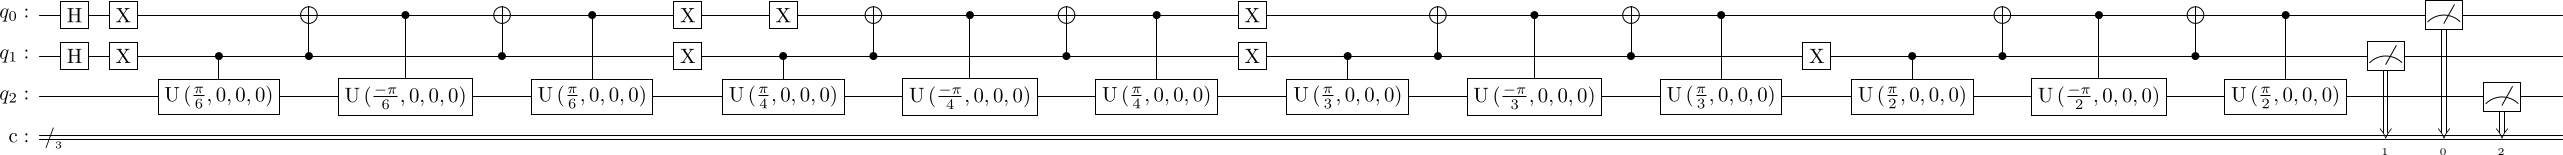

In [16]:
A_circ.draw(output="latex")

In [17]:
from math import log2, asin, sqrt
from typing import List
from qiskit import QuantumCircuit
from qiskit.circuit.library import StatePreparation
from qiskit_aer import AerSimulator

class QuantumAmplitudeEstimator:
    def __init__(self, window_size: int, shots: int = 1000) -> None:
        if window_size & (window_size - 1) != 0:
            raise ValueError("window_size must be a power of 2.")
        self.window_size = window_size
        self.n_index_qubits = int(log2(window_size))
        self.backend = AerSimulator()

    def _build_A_circuit(self, values: List[float], encode_power: int) -> QuantumCircuit:
        N = self.window_size
        n = self.n_index_qubits
        X_max = max(values)
        qc = QuantumCircuit(n + 1, n + 1)

        # 1) Uniform superposition on index qubits
        qc.h(range(n))

        # 2) Controlled-Ry on ancilla:
        ancilla = n
        for i in range(N):
            x_i = values[i]
            if encode_power == 1:
                sin_theta = sqrt(x_i / X_max)
            else:
                sin_theta = x_i / X_max
            sin_theta = max(0.0, min(1.0, sin_theta))
            theta = asin(sin_theta)
            angle = 2 * float(theta)

            bitstr = format(i, f"0{n}b")
            for q_idx, bit in enumerate(bitstr):
                if bit == "0":
                    qc.x(q_idx)
            qc.mcry(angle, list(range(n)), ancilla, None, mode="noancilla")
            for q_idx, bit in enumerate(bitstr):
                if bit == "0":
                    qc.x(q_idx)

        # 3) Measure all qubits
        qc.measure(range(n + 1), range(n + 1))
        return qc

# Build and display the ASCII diagram
data = [1.0, 2.0, 3.0, 4.0]
est = QuantumAmplitudeEstimator(window_size=4)
A_circ = est._build_A_circuit(data, encode_power=1)
print(A_circ.draw(output="text"))


     ┌───┐┌───┐                ┌───┐                 ┌───┐                ┌───┐»
q_0: ┤ H ├┤ X ├────────────────┤ X ├────────■────────┤ X ├───────■────────┤ X ├»
     ├───┤├───┤                └─┬─┘        │        └─┬─┘       │        ├───┤»
q_1: ┤ H ├┤ X ├───────■──────────■──────────┼──────────■─────────┼────────┤ X ├»
     └───┘└───┘┌──────┴───────┐     ┌───────┴───────┐     ┌──────┴───────┐└───┘»
q_2: ──────────┤ U(π/6,0,0,0) ├─────┤ U(-π/6,0,0,0) ├─────┤ U(π/6,0,0,0) ├─────»
               └──────────────┘     └───────────────┘     └──────────────┘     »
c: 3/══════════════════════════════════════════════════════════════════════════»
                                                                               »
«          ┌───┐      ┌───┐                 ┌───┐                ┌───┐»
«q_0: ─────┤ X ├──────┤ X ├────────■────────┤ X ├───────■────────┤ X ├»
«          └───┘      └─┬─┘        │        └─┬─┘       │        ├───┤»
«q_1: ───────■──────────■──────────┼──────────■────────

# Phase-Estimation-Based QAE

In [ ]:
from math import log2, asin, sqrt, pi, ceil
from typing import List, Tuple

import numpy as np
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator


class QuantumAmplitudeEstimatorPE:
    """
    Phase‐Estimation based Amplitude Estimation (QAE) for mean & variance.
    - window_size must be a power of 2 (N points).
    - We choose n_phase_qubits so that the mean estimate is within ±0.1.
    """

    def __init__(self, window_size: int) -> None:
        if window_size & (window_size - 1) != 0:
            raise ValueError("window_size must be a power of 2.")
        self.window_size = window_size
        self.n_index_qubits = int(log2(window_size))
        # We'll set n_phase_qubits inside predict(...)
        self.n_phase_qubits = None
        self.backend = AerSimulator()

    def _construct_A_block(self, values: List[float], encode_power: int) -> QuantumCircuit:
        """
        Build A on (n_index_qubits + 1) qubits (no measurements):
          |0^n> |0> -> (1/sqrt(N)) sum_i |i>[ cos θ_i |0> + sin θ_i |1> ]
        where sin²θ_i = (x_i / X_max)   if encode_power=1,
                     = (x_i / X_max)^2 if encode_power=2.
        """
        N = self.window_size
        n = self.n_index_qubits
        X_max = max(values)
        if X_max <= 0:
            raise ValueError("All data values are zero; cannot normalize.")

        qc = QuantumCircuit(n + 1)
        # 1) Uniform superposition on index qubits
        qc.h(range(n))

        anc = n
        for i in range(N):
            x_i = values[i]
            if encode_power == 1:
                sin_theta = sqrt(x_i / X_max)
            else:
                sin_theta = x_i / X_max
            sin_theta = max(0.0, min(1.0, sin_theta))
            theta = asin(sin_theta)
            angle = 2.0 * float(theta)

            bitstr = format(i, f"0{n}b")
            # 2a) Flip index qubits where bit = '0'
            for q_idx, bit in enumerate(bitstr):
                if bit == "0":
                    qc.x(q_idx)
            # 2b) Multi‐controlled Ry(angle) on ancilla
            qc.mcry(angle, list(range(n)), anc, None, mode="noancilla")
            # 2c) Undo the X‐flips
            for q_idx, bit in enumerate(bitstr):
                if bit == "0":
                    qc.x(q_idx)

        return qc

    def _construct_S0(self) -> QuantumCircuit:
        """
        Reflection S0 on (n_index_qubits + 1): flips the sign of |0^n>|0> only.
        Implemented as:
          X on all index qubits + X on ancilla
          H on ancilla → MCX (controls = index qubits, target = ancilla) → H on ancilla
          Undo all X’s.
        """
        n = self.n_index_qubits
        anc = n
        qc = QuantumCircuit(n + 1)

        qc.x(range(n))
        qc.x(anc)
        qc.h(anc)
        qc.mcx(list(range(n)), anc)
        qc.h(anc)
        qc.x(anc)
        qc.x(range(n))

        return qc

    def _construct_Q_block(self, values: List[float], encode_power: int) -> QuantumCircuit:
        """
        Build Q = A · S0 · A† · Sχ on (n_index_qubits + 1) qubits.
        Here Sχ = Z on the ancilla (i.e. flips phase if ancilla=1).
        The eigenphases in the 2D “good/bad” subspace are ±2θ where sin²θ = a.
        """
        n = self.n_index_qubits

        A_block = self._construct_A_block(values, encode_power)
        S0_block = self._construct_S0()
        # Sχ = Z on ancilla
        S_chi = QuantumCircuit(n + 1)
        S_chi.z(n)

        Qc = QuantumCircuit(n + 1)
        Qc.append(A_block.to_gate(label="A"), list(range(n + 1)))
        Qc.append(S0_block.to_gate(label="S0"), list(range(n + 1)))
        Qc.append(A_block.inverse().to_gate(label="A†"), list(range(n + 1)))
        Qc.append(S_chi.to_gate(label="Sχ"), list(range(n + 1)))
        return Qc

    def _inverse_qft(self, m: int) -> QuantumCircuit:
        """
        Build an m‐qubit inverse QFT (no measurements).
        Standard decomposition: controlled‐phase + H + final swaps.
        """
        qc = QuantumCircuit(m)
        for i in reversed(range(m)):
            for j in range(i + 1, m):
                angle = -pi / (2 ** (j - i))
                qc.cp(angle, j, i)
            qc.h(i)
        for i in range(m // 2):
            qc.swap(i, m - 1 - i)
        return qc

    def _phase_estimation_circuit(self,
                                  values: List[float],
                                  encode_power: int) -> QuantumCircuit:
        """
        Build the full QPE circuit on:
          • m = self.n_phase_qubits (phase register)
          • n = self.n_index_qubits (index register)
          •  1 ancilla qubit
        We measure all (m + n + 1) qubits; we only read the first m bits for φ.
        """
        if self.n_phase_qubits is None:
            self.n_phase_qubits = 3
        m = self.n_phase_qubits
        n = self.n_index_qubits
        total_qubits = m + (n + 1)
        qc = QuantumCircuit(total_qubits, m + (n + 1))

        # 1) Hadamard on all m phase qubits
        qc.h(range(m))

        # 2) Prepare index+ancilla via A (on qubits m..m+n)
        idx_qubits = list(range(m, m + n))
        anc_qubit = m + n
        qc.append(self._construct_A_block(values, encode_power).to_gate(label="A"),
                  idx_qubits + [anc_qubit])

        # 3) Controlled-Q^(2^j) for j=0..m-1
        Q_gate = self._construct_Q_block(values, encode_power).to_gate(label="Q")
        for j in range(m):
            exponent = 2 ** j
            Qpow = Q_gate.power(exponent)   # Q^{2^j}
            cQpow = Qpow.control(1)
            qc.append(cQpow, [j] + idx_qubits + [anc_qubit])

        # 4) Inverse QFT on the first m qubits
        qc.append(self._inverse_qft(m).to_gate(label="IQFT"), list(range(m)))

        # 5) Measure: phase register → classical [0..m-1], index+ancilla → classical [m..m+n]
        qc.measure(range(m), range(m))
        qc.measure(idx_qubits + [anc_qubit], range(m, m + n + 1))

        return qc

    def _estimate_amplitude_pe(self,
                               values: List[float],
                               encode_power: int) -> float:
        """
        Run QPE once (shots=1) to estimate a = E[f(i)],
        where f(i) = x_i/X_max (encode_power=1) or (x_i/X_max)^2 (encode_power=2).

        Returns sin²(φ_est/2).  If a=1 or a=0 exactly, we short-circuit.
        """
        X_max = max(values)
        if encode_power == 1:
            f_vals = [(x / X_max) for x in values]
        else:
            f_vals = [(x / X_max) ** 2 for x in values]

        # If all f(i)=1 → a=1 exactly.  Or all f(i)=0 → a=0.
        if all(abs(fi - 1.0) < 1e-12 for fi in f_vals):
            return 1.0
        if all(abs(fi - 0.0) < 1e-12 for fi in f_vals):
            return 0.0

        # Build and run the QPE circuit
        qc_pe = self._phase_estimation_circuit(values, encode_power)
        t_qc = transpile(qc_pe, self.backend)
        job = self.backend.run(t_qc, shots=1)
        result = job.result()
        counts = result.get_counts()
        bitstr, _ = next(iter(counts.items()))

        # Take the last m = self.n_phase_qubits bits as the phase register
        phase_bits = bitstr[-self.n_phase_qubits :]
        k = int(phase_bits, 2)  # in [0..2^m - 1]
        phi_est = 2 * np.pi * k / (2 ** self.n_phase_qubits)

        return float((np.sin(phi_est / 2)) ** 2)

    def predict(self, data: List[float]) -> Tuple[float, float]:
        """
        Estimate (mean, variance) for nonnegative `data` of length = window_size.

        We pick n_phase_qubits = ceil(log2(π·X_max / 0.1)) (min 3)
        so the mean estimate is within ±0.1.  Returns (mean_est, var_est).
        """
        if len(data) != self.window_size:
            raise ValueError(f"Expected {self.window_size} data points, got {len(data)}.")
        if any(x < 0 for x in data):
            raise ValueError("All data values must be nonnegative.")

        X_max = max(data)
        if X_max <= 0:
            return 0.0, 0.0

        # If all data = X_max exactly → mean = X_max, var = 0
        if all(abs(x - X_max) < 1e-12 for x in data):
            return float(X_max), 0.0

        # ── Choose m so Δ(E[X]) < 0.1:  2^m > π X_max / 0.1  ──
        tol = 0.1
        required = (pi * X_max) / tol
        m = max(3, int(ceil(log2(required))))
        self.n_phase_qubits = m

        # Pass 1: estimate a1 ≈ E[X]/X_max using QPE
        a1 = self._estimate_amplitude_pe(data, encode_power=1)
        E_X = a1 * X_max

        # Pass 2: estimate a2 ≈ E[X^2]/X_max^2 using QPE
        a2 = self._estimate_amplitude_pe(data, encode_power=2)
        E_X2 = a2 * (X_max ** 2)

        var_X = E_X2 - (E_X ** 2)
        return E_X, var_X


In [ ]:
data = np.zeros(32)
estimator = QuantumAmplitudeEstimatorPE(window_size=32)

# Build the A-circuit for the “mean” pass (encode_power=1)
qc = estimator._phase_estimation_circuit(data, encode_power=1)
qc.draw(output="latex")

ValueError: window_size must be a power of 2.

In [45]:
"""
test_quantum_amplitude_estimator.py

Test script for the corrected QuantumAmplitudeEstimator (Qiskit v2.0+),
which uses a uniform superposition over indices and measures the ancilla,
so that the quantum-estimated mean/variance match the classical arithmetic
mean/variance.

Run with:
    python test_quantum_amplitude_estimator.py
"""

import numpy as np

# If the QuantumAmplitudeEstimator class is in a separate module, import it:
# from quantum_amplitude_estimator import QuantumAmplitudeEstimator

# Otherwise, if the class definition is in the same file, skip the import above.

def run_test_case(data: np.ndarray, shots: int, tol: float):
    """
    Instantiate the estimator on `data`, compare quantum vs classical mean & variance.
    """
    N = len(data)
    print(f"\nTesting data (length={N}): {data.tolist()}")

    # Classical mean and variance (arithmetic, uniform weights)
    mean_cl = np.mean(data)
    var_cl = np.var(data)

    # Create the quantum estimator
    qae = QuantumAmplitudeEstimatorPE(window_size=N)

    # Run quantum estimate
    mean_q, var_q = qae.predict(data.tolist())

    print(f" Classical mean = {mean_cl:.6f}, variance = {var_cl:.6f}")
    print(f" Quantum  mean = {mean_q:.6f}, variance = {var_q:.6f}")

    mean_diff = abs(mean_q - mean_cl)
    var_diff = abs(var_q - var_cl)

    if mean_diff > tol:
        print(f"  → WARNING: mean differs by {mean_diff:.6f} > tol={tol}")
    if var_diff > tol:
        print(f"  → WARNING: variance differs by {var_diff:.6f} > tol={tol}")

    assert mean_diff <= tol, f"Mean not within tolerance: |{mean_q} - {mean_cl}| = {mean_diff} ≥ {tol}"
    assert var_diff <= tol, f"Variance not within tolerance: |{var_q} - {var_cl}| = {var_diff} ≥ {tol}"
    print("Test PASSED.")


if __name__ == "__main__":
    np.random.seed(42)

    shots = 20_0000   # increase to reduce sampling error
    tol = 0.10       # allow ±0.10 absolute tolerance

    # Test case 1: uniform data → mean = 1.0, var = 0.0
    data1 = np.array([1.0, 1.0, 1.0, 1.0])
    run_test_case(data1, shots, tol)

    # Test case 2: ascending integers [1,2,3,4] → mean=2.5, var=1.25
    data2 = np.array([1.0, 2.0, 3.0, 4.0])
    run_test_case(data2, shots, tol)

    # Test case 3: random nonnegative floats of length 8
    data3 = np.random.rand(8) * 5.0
    run_test_case(data3, shots, tol)

    # Test case 4: all zeros → mean=0, var=0
    data4 = np.zeros(4)
    # Since no randomness, we can use a tighter tolerance
    run_test_case(data4, shots, tol=1e-6)

    print("\nAll tests completed successfully.")



Testing data (length=4): [1.0, 1.0, 1.0, 1.0]
 Classical mean = 1.000000, variance = 0.000000
 Quantum  mean = 1.000000, variance = 0.000000
Test PASSED.

Testing data (length=4): [1.0, 2.0, 3.0, 4.0]
 Classical mean = 2.500000, variance = 1.250000
 Quantum  mean = 3.028205, variance = 6.829972
  → WARNING: mean differs by 0.528205 > tol=0.1
  → WARNING: variance differs by 5.579972 > tol=0.1


AssertionError: Mean not within tolerance: |3.028205488386443 - 2.5| = 0.5282054883864431 ≥ 0.1